In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
import jax.numpy as jnp
from jax.random import PRNGKey

import numpy as np
import matplotlib.pyplot as plt
import diffrax

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant, CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import (
    AlternatingActiveSetLMSolver,
    LMSettings,
    AnnealedAlternatingActiveSetLMSolver,
)
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

from jsindy.util import get_collocation_points_weights

from pysindy import STLSQ

# Configure
jax.config.update("jax_enable_x64", True)
plt.style.use("ggplot")
from jax.random import PRNGKey
annealing = False


/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [2]:
# Random key
seed = 1234
rkey = PRNGKey(seed=seed)

In [3]:
dt = 0.005
noise = 0.01
# noise = 0.0
dt_train = 2

n_colloc = 500

x0 = -3.20767361e-02       # initial displacement
# x0 = -0.2
# dx0 = 0.0
dx0 = 1.28199828e-03      # initial velocity

t0 = 0.0
t1 = 100.0
initial_state = jnp.array([x0, dx0])

args = (0.5,)

# def ode_sys(t, state, args):
#     x, dx = state
#     dxdt = dx
#     dydt = -1*jnp.sin(x)
#     return jnp.array([dxdt,dydt])

def ode_sys(t,state, args):
    mu = args[0]
    x, dx = state
    dxdt = dx
    dydt = mu*(1-x**2)*dx-x
    return jnp.array([dxdt,dydt])

term = diffrax.ODETerm(ode_sys)
solver = diffrax.Tsit5()

save_at = diffrax.SaveAt(dense=True)

sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt,  # Initial step size
    y0=initial_state,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

In [4]:
t_true = jnp.arange(t0,t1,dt)
X_true = jax.vmap(sol.evaluate)(t_true)

t_train = jnp.arange(t0,t1, dt_train)
extra_t_train= jnp.linspace(0,5,5)[1:]
t_train = jnp.hstack([t_train,extra_t_train])
t_as = jnp.argsort(t_train)
t_train = t_train[t_as]


X_train_true = jax.vmap(sol.evaluate)(t_train)

# X_train_true = jnp.vstack(
#     [
#         X_train_true,
#         jax.vmap(sol.evaluate)(extra_t_train)
#     ]
# )[t_as]

X_train = X_train_true + noise*jax.random.normal(rkey,X_train_true.shape)

t_colloc, w_colloc = get_collocation_points_weights(t_train, n_colloc)

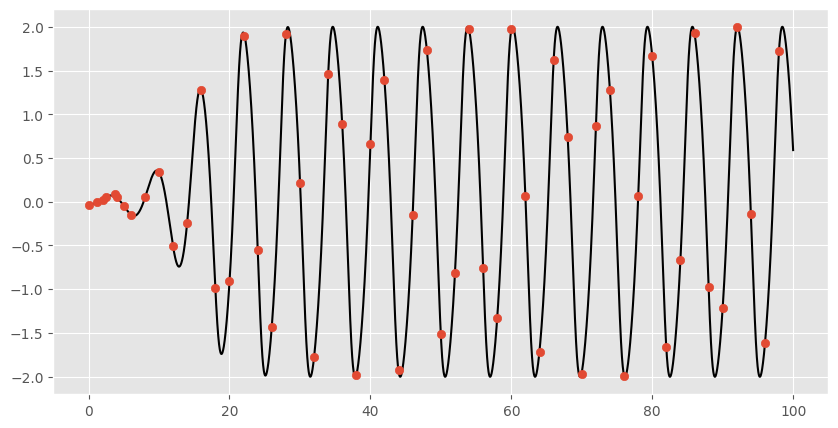

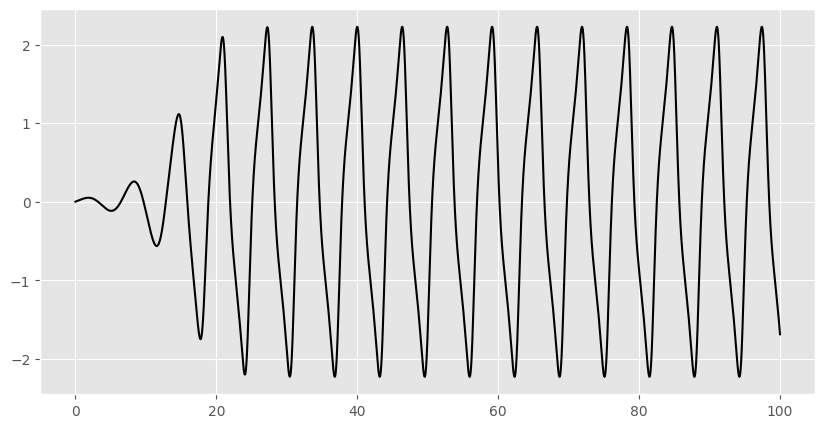

In [5]:
plt.figure(figsize=(10,5))
plt.plot(t_true, X_true[:,0],c='black')
plt.scatter(t_train, X_train[:,0],zorder=2)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(t_true, X_true[:,1],c='black')

In [6]:
kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=2.0)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel,derivative_orders=(0,1,2))
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
sparsifier = pySindySparsifier(STLSQ(threshold = 0.1,alpha = 0.01))

if not annealing:
    optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=1e5,
        fixed_data_weight=1,
        sparsifier = sparsifier,
    )
else:
    optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=1e4,
        fixed_data_weight=1,
        sparsifier = sparsifier,
        num_annealing_steps=4,
    )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, 1),
    ode_order=2,
    feature_names=['x']
)

In [7]:
model.fit(
    t = t_train,
    x = X_train[:,0].reshape(-1,1),
    t_colloc=t_colloc
)
model.print()

{'show_progress': True, 'sigma2_est': Array(1.00000285e-06, dtype=float64), 'data_weight': 1, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 7.42, gradnorm = 2.174e+03, alpha = 4.167, improvement_ratio = 0.9875
Iteration 1, loss = 0.2353, gradnorm = 1.263e+03, alpha = 3.472, improvement_ratio = 0.9986
Iteration 2, loss = 0.2022, gradnorm = 83.31, alpha = 2.894, improvement_ratio = 0.9655
Iteration 3, loss = 0.1901, gradnorm = 54.58, alpha = 2.411, improvement_ratio = 0.9592
Iteration 4, loss = 0.1838, gradnorm = 38.55, alpha = 2.009, improvement_ratio = 0.9734
Iteration 5, loss = 0.1805, gradnorm = 22.76, alpha = 1.674, improvement_ratio = 0.9869
Iteration 61, loss = 0.09465, gradnorm = 5.362e-09, alpha = 0.0001533, improvement_ratio = inf
Model after smooth warm start
(x)'' = -1.046 x + 0.477 (x') + -0.001 x^2 + -0.007 x (x') + 0.005 (x')^2 + 0.021 x^3 + -0.304 x^2 (x') + 0.020 x (x')^2 + -0.059 (x')^3
Alternating Activeset Sparsifier
7 active coeffs changed
Active set stabilized
(x)'' = -0.985 x + 0.352 (x') + -0.349 x^2 (x')


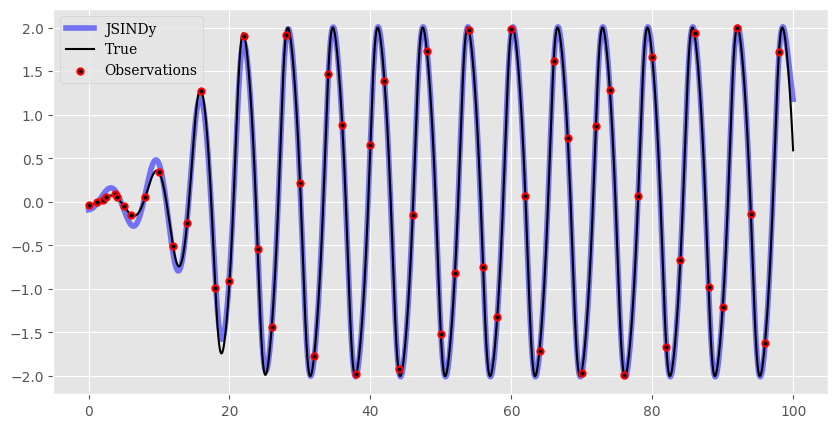

In [8]:
x_pred = model.predict_state(t_true)

plt.figure(figsize=(10,5))
plt.plot(t_true, x_pred, label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true, X_true[:,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 2, facecolors='black', edgecolors='red', label="Observations", s=20,lw=1.5)
plt.legend(prop={'family':'serif'})
plt.show()

In [9]:
mse_linear = jnp.mean((X_true[:,0] - x_pred[:,0])**2,axis=0)/jnp.var(X_true[:,0],axis=0)
print(mse_linear)

0.0017791441725665048


In [10]:
# X_train[:,1], X_train[:,0],

In [11]:
def model_state_pred(t,state,args):
    x, dx = state
    dxdt = dx
    return jnp.array([dxdt,model.predict(jnp.array(state))[0]])

model_term = diffrax.ODETerm(model_state_pred)

new_start = t1 - 0.02
new_start = t1
new_init = sol.evaluate(new_start)
sol_continue = diffrax.diffeqsolve(
    term,
    solver,
    t0=new_start,
    t1=2*t1,
    dt0=dt,
    y0=new_init,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

simulated_sol = diffrax.diffeqsolve(
    model_term,
    solver,
    t0=new_start,
    t1=2*t1,
    dt0=dt,
    y0=new_init,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

In [12]:
new_init

Array([ 0.58303083, -1.6918515 ], dtype=float64)

In [13]:
X_true[-1]

Array([ 0.59147582, -1.68614894], dtype=float64)

In [14]:
model.predict(X_true[-1])

Array([-0.97012449], dtype=float64)

In [15]:
model_state_pred(None, X_true[-1], None)

Array([-1.68614894, -0.97012449], dtype=float64)

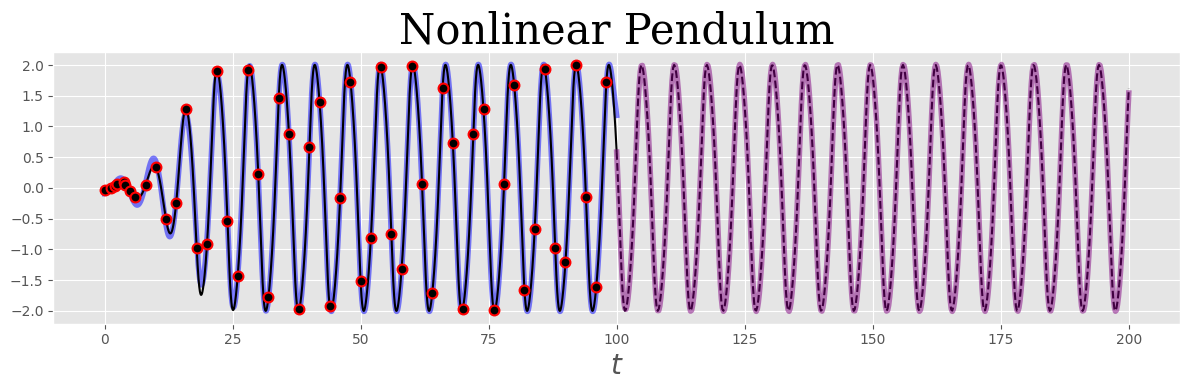

In [16]:
new_grid = jnp.linspace(t1,2*t1,500)
# plt.plot(new_grid,jax.vmap(sol_continue.evaluate)(new_grid)[:,0])
# plt.plot(new_grid,jax.vmap(simulated_sol.evaluate)(new_grid)[:,0])

# plt.show()

true_forward = jax.vmap(sol_continue.evaluate)(new_grid)[:,0]
learned_forward = jax.vmap(simulated_sol.evaluate)(new_grid)[:,0]

cutoff = -1
plt.figure(figsize=(12,4))
plt.plot(t_true[:cutoff], x_pred[:cutoff], label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true[:cutoff], X_true[:cutoff,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=50,lw=1.5)


plt.plot(new_grid, true_forward,linestyle="--", c='black', label="True Unseen Trajectory")
plt.plot(new_grid, learned_forward, c='purple', lw=4, label="Simulated Dynamics",alpha=0.5)

plt.xlabel(r"$t$",size=20, family='serif')
# plt.legend(prop={'family':'serif'},loc='right')
plt.title(r"Nonlinear Pendulum",size=30, family='serif')
plt.tight_layout()
# if savefig: 
#     plt.savefig("non-linear-pendulum.pdf")
plt.show()